In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import numpy as np
import pandas as pd
import requests
import tqdm
import re
from os import path

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [31]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

model_file_name = 'homework-stage-1'
model_file_name_unfreezed = 'homework-stage-2'

Mounted at /content/gdrive


In [6]:
df = pd.read_json(base_dir + 'crack_classification.json')

df['label'] = df.annotation.apply(lambda x: x['labels'][0] \
                                  if len(x['labels']) == 1 else 'Crack') 

df[['content', 'label']].head()

,content,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,no Crack


In [7]:
df[['content', 'label']].describe()

,content,label
count,1428,1428
unique,1428,2
top,http://com.dataturks.a96-i23.open.s3.amazonaws...,no Crack
freq,1,771


In [8]:
# need to be only run once, then files are stored locally
for url in tqdm.tqdm(df['content']):
  
  filename = re.findall("\d+.jpg$", url)
  filepath = path.join(base_dir, "images", filename[0])

  if path.exists(filepath):
    continue

  r = requests.get(url, stream=True)

  if r.status_code == 200:
    with open(filepath, 'wb') as f:
        for chunk in r:
            f.write(chunk)

100%|██████████| 1428/1428 [00:11<00:00, 129.74it/s]


In [9]:
bs = 64

path_img = os.path.join(base_dir, "images")

df['images'] = df.content.apply(lambda x: re.findall('\d+.jpg$', x)[0])

data = ImageDataBunch.from_df(path_img, df[["images", "label"]], 
                              ds_tfms=get_transforms(), size=224, bs=bs
                              ).normalize(imagenet_stats)

print(data.classes)
len(data.classes),data.c

['Crack', 'no Crack']


(2, 2)

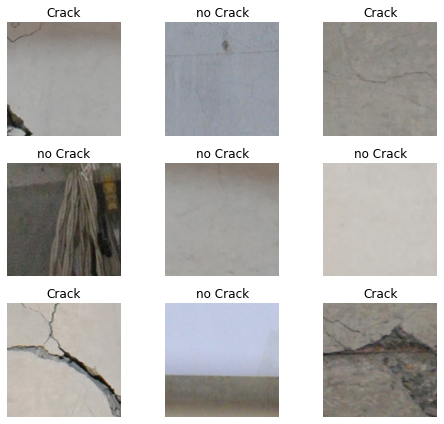

In [10]:
data.show_batch(rows=3, figsize=(7,6))

## Restnet

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
if path.exists(path.join(base_dir, f"{model_file_name}.pth")):
  print("Model already trained and saved")
else: 
  learn.fit_one_cycle(4)

Model already trained and saved


In [14]:
!ls gdrive/My\ Drive/fastai-v3

crack_classification.json  images	   stage-1.pth	   stage-2.pth
homework-stage-1.pth	   stage-1-50.pth  stage-2-50.pth


In [0]:
if path.exists(path.join(base_dir, f"{model_file_name}.pth")): 
  learn.load(base_dir + model_file_name)
else:
  learn.save(base_dir + model_file_name)

## Results

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

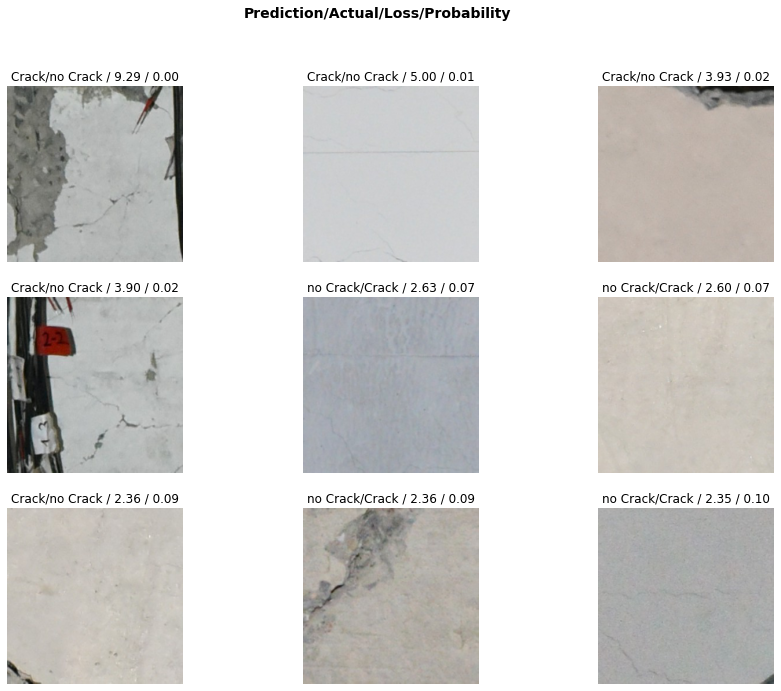

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
doc(interp.plot_top_losses)

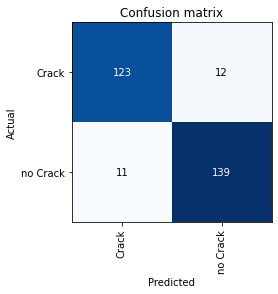

In [26]:
interp.plot_confusion_matrix()

In [20]:
interp.most_confused(min_val=2)

[('Crack', 'no Crack', 12), ('no Crack', 'Crack', 11)]

## Unfreezing, fine-tuning, and learning rates

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


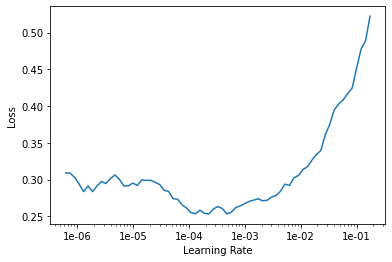

In [25]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.295645,0.334009,0.087719,00:11
1,0.227966,0.274880,0.073684,00:11


In [0]:
learn.save(base_dir + model_file_name_unfreezed)

## Reference

https://towardsdatascience.com/anomaly-detection-in-images-777534980aeb